# Processing Planet imagery

This notebook contains code for processing imagery from Planet Labs. The image files are PlanetScope Analytic SR Ortho Scenes (Product Level 3B) with a 16-bit bit depth. These are the equivalent of raw image files suitable for analytic and scientific analyses. The goal of this notebook is to process these images into tiled RGB image directories suitable for use in generating labeled training data for TensorFlow.

In [1]:
from IPython.display import Image
import rasterio
import skimage
import os
from skimage import exposure
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from rasterio.plot import show
from osgeo import gdal

We will be working with a single image from Ningde, China in this notebook. 

In [42]:
# Load PlanetScope 4-band analytic-sr image
filename = "img/raw_tiffs/20180410_020421_0f31_3B_AnalyticMS_SR.tif"
# Save the image name for later filenaming use
image_name = '20180410_020421_0f31_3B_AnalyticMS_SR'

## Loading Images
First, let's define some helper functions for loading PlanetScope 4-band image scenes

In [43]:
# Load all 4 bands of PlanetScope scene
def load_image4(filename):
    """Return a 4D (r, g, b, nir) numpy array with the data in the specified TIFF filename."""
    with rasterio.open(filename) as src:
        b, g, r, nir = src.read()
        return np.dstack([r, g, b, nir])

# Load just the RGB bands of PlanetScope scene
def load_image3(filename):
    """Return a 3D (r, g, b) numpy array with the data in the specified TIFF filename."""
    with rasterio.open(filename) as src:
        b,g,r,mask = src.read()
        out_image = np.dstack([b, g, r])
        return out_image

Now let's open the image both as an image file and as an `numpy` array using the `load_image3` function defined above

In [44]:
# Load as image raster
imgA = rasterio.open(filename)
# Load as numpy array 
imgB = load_image3("img/raw_tiffs/20180410_020421_0f31_3B_AnalyticMS_SR.tif")

## Plotting Images

GeoTiffs can be readily plotted with the `rasterio.plot.show` method after reading the opened GeoTiff file with `read()`. However, the PlanetScope4 3B (analytic SR) scenes have not had a color ramp applied and therefore need to be processed before they can be readily visualized as a RGB image.

For example, consider what happens if no color map is applied prior to plotting:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


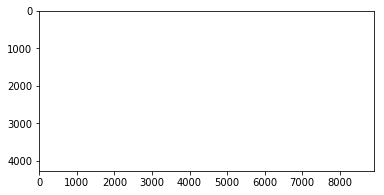

In [45]:
# Plot the second band of the entire image
show(imgA.read())

In this case, pixel values are assumed to be in the 8bit RGB range and are thus clipped to the appropriate range (depending on whether the data type is a `float` or `uint`, see above warning). Because the raw values are outside this range, we get the above uniform image. However, individual bands can be readily plotted because the pixel values for a single band can be normalized.

For example, let's plot the image's red band, which we can do by specifying the band number in the `read` method:

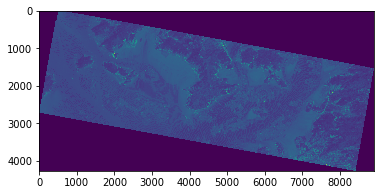

In [46]:
show(imgA.read(2))

### Color Rescaling

To visualize the image as a normal RGB image, we need to rescale the 16bit values down to 8bit. PlanetScope 4-band images also come with the band order blue/green/red/nir, so we need to select and reorder the first three bands to RGB.

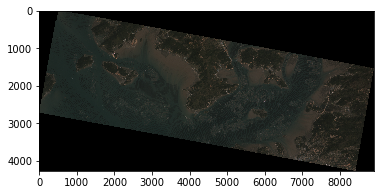

In [47]:
# Scale variable. Note bands of Planet imagery go BGR
imgC = exposure.rescale_intensity(imgA.read((3,2,1)), out_range='uint8')
# Plot image
show(imgC)

Let's save a new GeoTiff of this rescaled 8-bit image to use for labeling purposes.

In [48]:
# Get transform of original image
source_transform = imgA.transform
source_crs = imgA.crs

# Open a new GeoTiff data file in which to save the rescaled image
with rasterio.open(('img/rgb_tiffs/' + image_name + '_RGB.tif'), 'w', driver='GTiff',
                       height=imgC.shape[1], width=imgC.shape[2], count=3,
                       dtype=rasterio.ubyte, crs=source_crs, 
                       transform=source_transform) as new_img:
    # Write the rescaled image to the new GeoTiff
    new_img.write(imgC.astype('uint8'))

/Users/Tyler-SFG/anaconda/envs/planet/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/Tyler-SFG/anaconda/envs/planet/lib/python3.6/site-packages/rasterio/__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


## Windowed Reading/Writing of Images

In [7]:
# Read in a 256x256 subset of the image file
with rasterio.open(filename) as src:
    chip = src.read((3,2,1), window=((1000,1256), (1000,1256)))

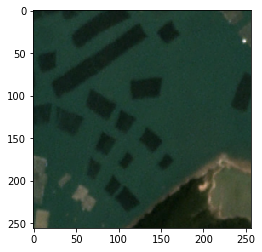

In [8]:
# Scale variable. Note bands of Planet imagery go BGR
chip = exposure.rescale_intensity(chip, out_range='uint8')
show(chip)

## Tiling GeoTiff Images

Individual PlanetScope scenes are very large (4,267 x 8,917 pixels, or 12.8 x 26.75 kilometers) and, in order to see the fine details, we need to be able to zoom in on the image. This is especially important for annotating the images with accurate labels that will be used to create training data for TensorFlow. To accomplish this, map services like GoogleEarth and Leaflet use image **tiles**. Essentially, the image is cut into a grid of "tiles" of various sizes that allow map viewers to seamlessly scroll around an image and zoom in/out.  

Creating map tiles from a GeoTiff equates to generating a directory with the tiles for various zoom levels saved in their own subdirectories. This task can be accomplished with the `gdal2tiles.py` function.

Let's now tile the RGB image created above:

In [54]:
# Construct GDAL command
cmd = 'gdal2tiles.py -z 10-16 ' + filename + ' img/tiles/' + image_name

# Run command in the shell
os.system(cmd)

0